In This Notebook: 
 - find best fit inclination, line of nodes, and central distance 
 - best fit values are found for a variety of distance data
 - Monte Carlo to determine uncertainties in best fit values 

In [1]:
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table 
import utils
import scipy.optimize as sp

In [2]:
def roi_cut(xcut,ycut,x,y): 
    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)
    return ind, cutind
    print (ind, cutind)

In [3]:
acat = Table(fits.getdata('LMC_EDR3_dist2.fits'))
acat['parallax'] = acat['parallax'] + 0.02329026
acat['dist'] = 1/acat['parallax']

In [4]:
xcut = [102.163978, 97.506720, 91.962366, 84.939516, 74.294355, 68.158602, 61.801075, 60.692204, 60.618280, 63.131720, 66.975806, 75.698925, 84.274194, 90.557796, 98.467742, 102.163978]
ycut = [-67.067100, -63.603896, -61.493506, -60.357143, -59.870130, -61.655844, -66.309524, -71.179654, -73.290043, -75.183983, -76.536797, -77.510823, -77.294372, -76.969697, -74.642857, -71.720779]
x = acat['ra'].ravel()
y = acat['dec'].ravel()

(ind, cutind) = roi_cut(xcut,ycut,x,y)


In [5]:
xcut2 = [78.877688, 83.830645, 87.083333, 86.787634, 83.534946, 77.990591, 74.737903, 68.750000, 66.606183, 70.524194, 75.403226]
ycut2 = [-68.095238, -68.311688, -70.530303, -71.937229, -73.452381, -72.424242, -72.099567, -72.099567, -70.205628, -67.662338, -67.229437]
x2 = acat['ra'].ravel()[cutind]
y2 = acat['dec'].ravel()[cutind]

(ind2, cutind2) = roi_cut(xcut2,ycut2,x2,y2)


In [3]:
def InclineDiskDist(ra, dec, pa, io, d0):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(82.25) #ra of LMC center
    delt0 = np.radians(-69.50) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa + 90) #np.radians(149.37)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dist = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    plx = 1/dist
    return dist, plx


In [4]:
def creatediskmodel(theta, inclin, Distcenter):
    dtype=np.dtype([('ra',float),('dec',float),('distheory',float),('plxtheory',float)])
    cat = np.zeros([111,51], dtype=dtype)
    for x in range (111):
        ra=(x/2)+55
        for y in range (51):
            dec=(y/2)-80
            (dist, plx) = InclineDiskDist(ra,dec,theta,inclin,Distcenter)
            cat[x,y]['ra']=ra
            cat[x,y]['dec']=dec
            cat[x,y]['distheory']=dist
            cat[x,y]['plxtheory']=plx
    return cat

In [5]:
x0=np.array([150,25,49],dtype=float)

def findbestdiskmodel(cat):
    def residuals(x):
        model=creatediskmodel(x[0], x[1], x[2])
        return ((cat['parallax'].ravel()[cutind][ind2] - model['plxtheory'].ravel()[cutind][ind2])/cat['sigma'].ravel()[cutind][ind2])
    soln=sp.least_squares(residuals, x0, bounds=([0, 0, 0], [360, 90, np.inf]), f_scale=0.1)
    theta = soln.x[0] 
    inclin = soln.x[1]
    Distcenter = soln.x[2]
    return theta, inclin, Distcenter

In [9]:
findbestdiskmodel(acat)

(169.73759129556956, 57.417626988631675, 44.93038550961866)

In [10]:
mod = creatediskmodel(169.73759129556956, 57.417626988631675, 44.93038550961866)

Text(0.5,1,'Distance Model [kpc]')

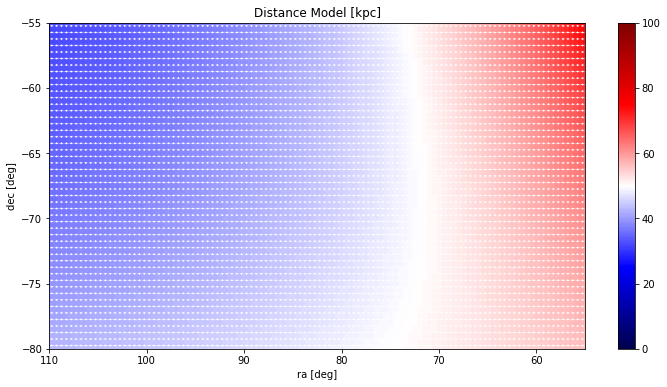

In [11]:
plt.figure(figsize=(12,6))
plt.scatter(mod['ra'], mod['dec'], c=mod['distheory'], s=30, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.xlim([110,55])
plt.ylim([-80,-55])
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.title('Distance Model [kpc]')

In [12]:
acat2 = Table(fits.getdata('LMC_EDR3_dist3.fits'))
acat2['parallax'] = acat2['parallax'] + 0.023357
acat2['dist'] = 1/acat2['parallax']

In [13]:
findbestdiskmodel(acat2)

(169.69983537388046, 57.60181179251742, 45.2913541513142)

In [14]:
mod2 = creatediskmodel(169.69983537388046, 57.60181179251742, 45.2913541513142)

Text(0.5,1,'Distance Model [kpc]')

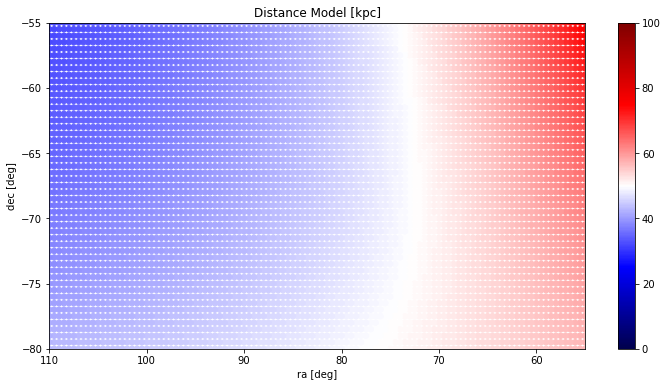

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(mod2['ra'], mod2['dec'], c=mod2['distheory'], s=30, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.xlim([110,55])
plt.ylim([-80,-55])
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.title('Distance Model [kpc]')

In [44]:
dtype=np.dtype([('theta',float),('inclin',float),('distcenter',float)])
MC = np.zeros(100, dtype=dtype)

model = creatediskmodel(169.73759129556956, 57.417626988631675, 44.93038550961866)

for t in range(100):
    synth = acat.copy()
    synth['parallax'] = model['plxtheory'] + np.random.randn(model.shape[0],model.shape[1])*acat['sigma']
    theta, inclin, distcenter = findbestdiskmodel(synth)
    MC[t]['theta'] = theta
    MC[t]['inclin'] = inclin
    MC[t]['distcenter'] = distcenter

MC = Table(MC)
MC.write('LMC_EDR3_MC1.fits', format='fits')

In [45]:
dtype=np.dtype([('theta',float),('inclin',float),('distcenter',float)])
MC2 = np.zeros(100, dtype=dtype)

model = creatediskmodel(169.69983537388046, 57.60181179251742, 45.2913541513142)

for t in range(100):
    synth = acat2.copy()
    synth['parallax'] = model['plxtheory'] + np.random.randn(model.shape[0],model.shape[1])*acat2['sigma']
    theta, inclin, distcenter = findbestdiskmodel(synth)
    MC2[t]['theta'] = theta
    MC2[t]['inclin'] = inclin
    MC2[t]['distcenter'] = distcenter

MC2 = Table(MC2)
MC2.write('LMC_EDR3_MC2.fits', format='fits')

In [16]:
MC = Table(fits.getdata('LMC_EDR3_MC1.fits'))
MC2 = Table(fits.getdata('LMC_EDR3_MC2.fits'))

In [17]:
print('Uncertainty in line of nodes 1: {}'.format(np.std(MC['theta'])))
print('Uncertainty in inclination 1: {}'.format(np.std(MC['inclin'])))
print('Uncertainty in center distance 1: {}'.format(np.std(MC['distcenter'])))

Uncertainty in line of nodes 1: 1.5669317665611613
Uncertainty in inclination 1: 0.8350090351607115
Uncertainty in center distance 1: 0.11705824048032593


In [18]:
print('Uncertainty in line of nodes 2: {}'.format(np.std(MC2['theta'])))
print('Uncertainty in inclination 2: {}'.format(np.std(MC2['inclin'])))
print('Uncertainty in center distance 2: {}'.format(np.std(MC2['distcenter'])))

Uncertainty in line of nodes 2: 1.5127623097210725
Uncertainty in inclination 2: 0.8302618445567859
Uncertainty in center distance 2: 0.11454757186406961


In [ ]:
## Ask josh about mc mc 

In [19]:
acat3 = Table(fits.getdata('LMC_EDR3_dist4.fits'))
acat3['parallax'] = acat3['parallax'] + 0.02023734
acat3['dist'] = 1/acat3['parallax']

In [20]:
xcut3 = [102.163978, 97.506720, 91.962366, 84.939516, 74.294355, 68.158602, 61.801075, 60.692204, 60.618280, 63.131720, 66.975806, 75.698925, 84.274194, 90.557796, 98.467742, 102.163978]
ycut3 = [-67.067100, -63.603896, -61.493506, -60.357143, -59.870130, -61.655844, -66.309524, -71.179654, -73.290043, -75.183983, -76.536797, -77.510823, -77.294372, -76.969697, -74.642857, -71.720779]
x3 = acat3['ra'].ravel()
y3 = acat3['dec'].ravel()

(ind3, cutind3) = roi_cut(xcut3,ycut3,x3,y3)


In [22]:
xcut4 = [78.877688, 83.830645, 87.083333, 86.787634, 83.534946, 77.990591, 74.737903, 68.750000, 66.606183, 70.524194, 75.403226]
ycut4 = [-68.095238, -68.311688, -70.530303, -71.937229, -73.452381, -72.424242, -72.099567, -72.099567, -70.205628, -67.662338, -67.229437]
x4 = acat3['ra'].ravel()[cutind3]
y4 = acat3['dec'].ravel()[cutind3]

(ind4, cutind4) = roi_cut(xcut4,ycut4,x4,y4)


In [31]:
def findbestdiskmodel2(cat):
    def residuals(x):
        model=creatediskmodel(x[0], x[1], x[2])
        return ((cat['parallax'].ravel()[cutind3][ind4] - model['plxtheory'].ravel()[cutind3][ind4])/cat['sigma'].ravel()[cutind3][ind4])
    soln=sp.least_squares(residuals, x0, bounds=([0, 0, 0], [360, 90, np.inf]), f_scale=0.1)
    theta = soln.x[0] 
    inclin = soln.x[1]
    Distcenter = soln.x[2]
    return theta, inclin, Distcenter

In [26]:
findbestdiskmodel2(acat3)

(160.62265590152813, 72.40342560008446, 31.016148391891875)

In [27]:
acat4 = Table(fits.getdata('LMC_EDR3_dist5.fits'))
acat4['parallax'] = acat4['parallax'] + 0.0204175
acat4['dist'] = 1/acat4['parallax']

In [28]:
findbestdiskmodel2(acat4)

(160.63884785918117, 72.43146289184206, 31.086136002526)

In [29]:
xcut_new = [96.619624, 98.985215, 97.580645, 95.584677, 93.662634, 90.483871, 85.604839, 74.737903, 70.228495, 65.275538, 62.096774, 61.283602, 63.870968, 69.563172, 77.768817, 86.048387, 92.923387]
ycut_new = [-74.372294, -71.071429, -68.257576, -65.606061, -63.874459, -61.872294, -61.006494, -60.952381, -62.196970, -65.606061, -68.798701, -73.290043, -74.534632, -75.616883, -76.645022, -76.590909, -76.103896]
x_new = acat['ra'].ravel()
y_new = acat['dec'].ravel()

(ind_new, cutind_new) = roi_cut(xcut_new,ycut_new,x_new,y_new)


In [34]:
xcut_new2 = [78.877688, 83.830645, 87.083333, 86.787634, 83.534946, 77.990591, 74.737903, 68.750000, 66.606183, 70.524194, 75.403226]
ycut_new2 = [-68.095238, -68.311688, -70.530303, -71.937229, -73.452381, -72.424242, -72.099567, -72.099567, -70.205628, -67.662338, -67.229437]
x_new2 = acat['ra'].ravel()[cutind_new]
y_new2 = acat['dec'].ravel()[cutind_new]

(ind_new2, cutind_new2) = roi_cut(xcut_new2,ycut_new2,x_new2,y_new2)


In [47]:
def findbestdiskmodel3(cat):
    def residuals(x):
        model=creatediskmodel(x[0], x[1], x[2])
        return ((cat['parallax'].ravel()[cutind_new][ind_new2] - model['plxtheory'].ravel()[cutind_new][ind_new2])/cat['sigma'].ravel()[cutind_new][ind_new2])
    soln=sp.least_squares(residuals, x0, bounds=([0, 0, 0], [360, 90, np.inf]), f_scale=0.1)
    theta = soln.x[0] 
    inclin = soln.x[1]
    Distcenter = soln.x[2]
    return theta, inclin, Distcenter

In [40]:
findbestdiskmodel3(acat)

(165.15170135940798, 53.06266174031865, 45.522302084606075)

In [49]:
findbestdiskmodel3(acat2)

(165.1559657046548, 53.31425595932453, 45.890510930541055)

In [41]:
dtype=np.dtype([('theta',float),('inclin',float),('distcenter',float)])
MC_new = np.zeros(100, dtype=dtype)

model = creatediskmodel(165.15170135940798, 53.06266174031865, 45.522302084606075)

for t in range(100):
    synth = acat.copy()
    synth['parallax'] = model['plxtheory'] + np.random.randn(model.shape[0],model.shape[1])*acat['sigma']
    theta, inclin, distcenter = findbestdiskmodel(synth)
    MC_new[t]['theta'] = theta
    MC_new[t]['inclin'] = inclin
    MC_new[t]['distcenter'] = distcenter

MC_new = Table(MC_new)
MC_new.write('LMC_EDR3_MC3.fits', format='fits')

In [42]:
print('Uncertainty in line of nodes 1: {}'.format(np.std(MC_new['theta'])))
print('Uncertainty in inclination 1: {}'.format(np.std(MC_new['inclin'])))
print('Uncertainty in center distance 1: {}'.format(np.std(MC_new['distcenter'])))

Uncertainty in line of nodes 1: 1.678796164312435
Uncertainty in inclination 1: 1.1117151612278786
Uncertainty in center distance 1: 0.12923780835061932


In [45]:
xcut_new3 = [96.619624, 98.985215, 97.580645, 95.584677, 93.662634, 90.483871, 85.604839, 74.737903, 70.228495, 65.275538, 62.096774, 61.283602, 63.870968, 69.563172, 77.768817, 86.048387, 92.923387]
ycut_new3 = [-74.372294, -71.071429, -68.257576, -65.606061, -63.874459, -61.872294, -61.006494, -60.952381, -62.196970, -65.606061, -68.798701, -73.290043, -74.534632, -75.616883, -76.645022, -76.590909, -76.103896]
x_new3 = acat3['ra'].ravel()
y_new3 = acat3['dec'].ravel()

(ind_new3, cutind_new3) = roi_cut(xcut_new3,ycut_new3,x_new3,y_new3)


In [46]:
xcut_new4 = [78.877688, 83.830645, 87.083333, 86.787634, 83.534946, 77.990591, 74.737903, 68.750000, 66.606183, 70.524194, 75.403226]
ycut_new4 = [-68.095238, -68.311688, -70.530303, -71.937229, -73.452381, -72.424242, -72.099567, -72.099567, -70.205628, -67.662338, -67.229437]
x_new4 = acat3['ra'].ravel()[cutind_new3]
y_new4 = acat3['dec'].ravel()[cutind_new3]

(ind_new4, cutind_new4) = roi_cut(xcut_new4,ycut_new4,x_new4,y_new4)


In [52]:
def findbestdiskmodel4(cat):
    def residuals(x):
        model=creatediskmodel(x[0], x[1], x[2])
        return ((cat['parallax'].ravel()[cutind_new3][ind_new4] - model['plxtheory'].ravel()[cutind_new3][ind_new4])/cat['sigma'].ravel()[cutind_new3][ind_new4])
    soln=sp.least_squares(residuals, x0, bounds=([0, 0, 0], [360, 90, np.inf]), f_scale=0.1)
    theta = soln.x[0] 
    inclin = soln.x[1]
    Distcenter = soln.x[2]
    return theta, inclin, Distcenter

In [53]:
findbestdiskmodel4(acat3)

(160.97571708692902, 70.1992268056745, 33.90845236747339)

In [54]:
findbestdiskmodel4(acat4)

(160.99029684567608, 70.29714704466603, 33.92519043584207)

In [43]:
df1 = Table(fits.getdata('LMC_EDR3_w_cut1.fits'))
df2 = Table(fits.getdata('LMC_EDR3_w_cut2.fits'))

In [55]:
from scipy.stats import binned_statistic_2d 

In [64]:
def findbestdiskmodel5(cat):
    def residuals(x):
        model=creatediskmodel(x[0], x[1], x[2])
        return ((cat['parallax'].ravel()[cutind_new][ind_new2] - model['plxtheory'].ravel()[cutind_new][ind_new2])/0.00611)
    soln=sp.least_squares(residuals, x0, bounds=([0, 0, 0], [360, 90, np.inf]), f_scale=0.1)
    theta = soln.x[0] 
    inclin = soln.x[1]
    Distcenter = soln.x[2]
    return theta, inclin, Distcenter

In [65]:
findbestdiskmodel5(acat)

(155.25453543388574, 44.471778126777124, 42.76402590450338)